In [1]:
from pathlib import Path
import json
import pandas as pd
import sys
from pathlib import Path
sys.path.append('../src')
from config import PROJECT_DIR, VOC_CLASSES, LABELS_DIR, TRUE_LABELS_CSV, RESULTS_DIR, HISTORIES_DIR

TEST_JSON = PROJECT_DIR / "data" / "preprocessed_jsons" / "test.json"

# Load test data
with open(TEST_JSON) as f:
    test_data = json.load(f)

# Process data to match the format of predicted.csv
true_labels_list = []
for item in test_data:
    image_name = item['file_path']
    labels = [0] * 20  # Assuming 20 possible labels
    for obj in item['object_labels']:
        label_index = VOC_CLASSES[obj['name']]
        labels[label_index] = 1
    true_labels_list.append([image_name] + labels)

# Create a DataFrame
true_labels_df = pd.DataFrame(true_labels_list, columns=['image_name'] + [str(i) for i in range(20)])

# Save to CSV
true_labels_df.to_csv(TRUE_LABELS_CSV, index=False)

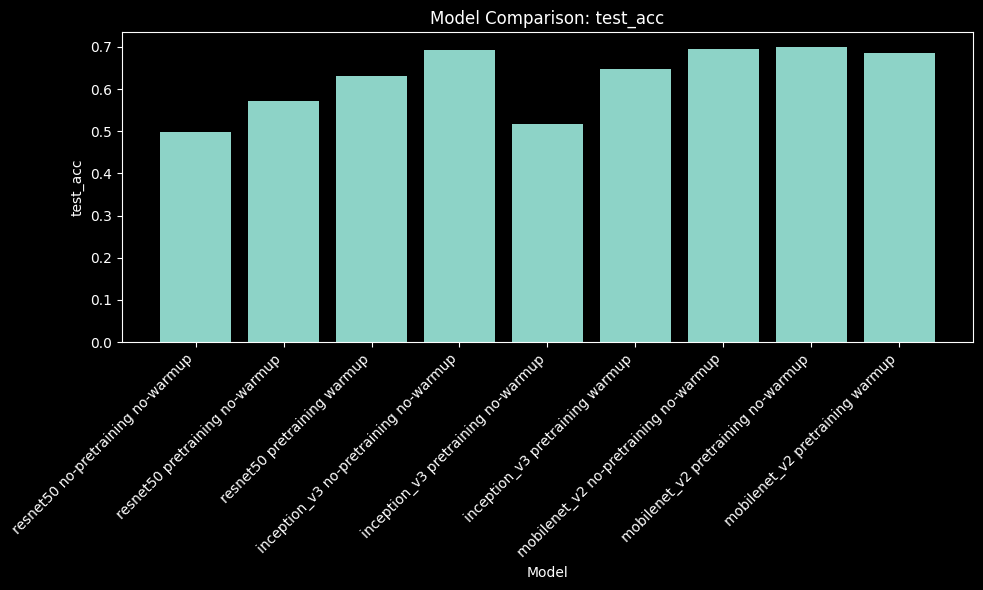

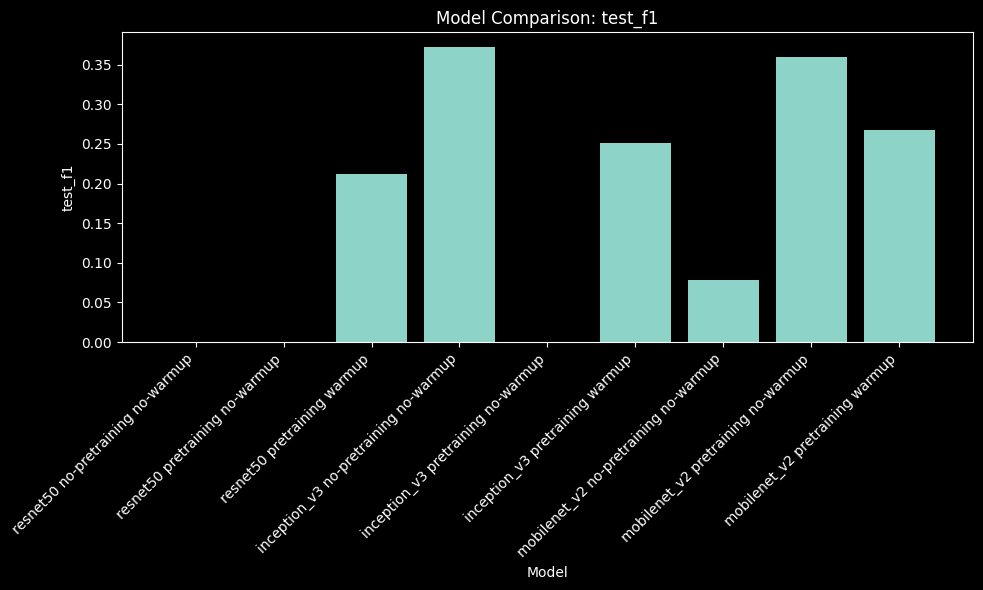

In [2]:
import matplotlib.pyplot as plt

# Load model performance data
model_performance_path = RESULTS_DIR / "model-experiments.csv"
model_performance = pd.read_csv(model_performance_path)

# Plot bar graphs for accuracy and F1 score
metrics = ['test_acc', 'test_f1']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.bar(model_performance['title'], model_performance[metric])
    plt.title(f'Model Comparison: {metric}')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

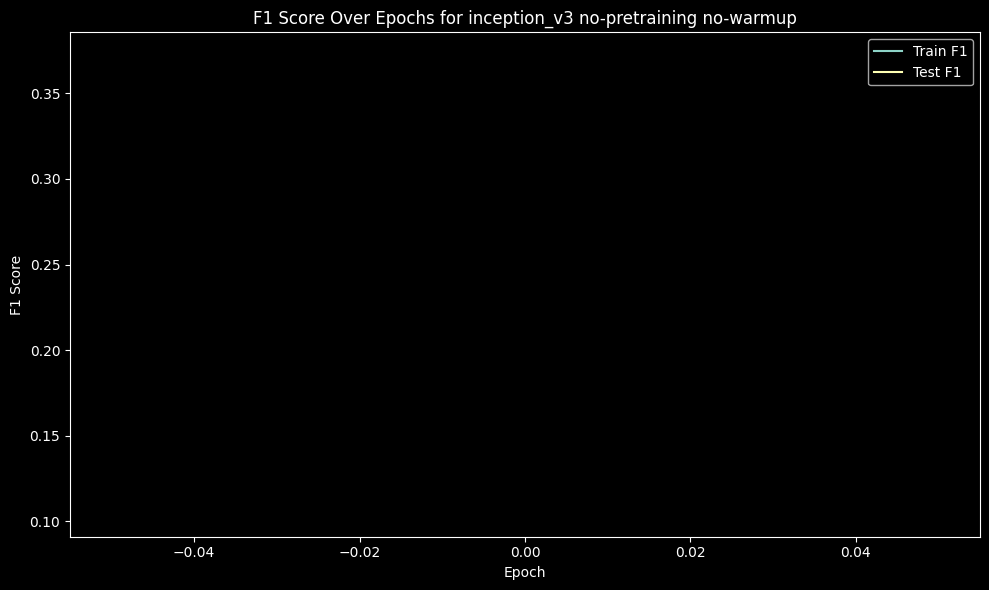

In [3]:
# Identify the best model based on F1 score
best_model_id = model_performance.loc[model_performance['test_f1'].idxmax(), 'id']
best_model_title = model_performance.loc[model_performance['test_f1'].idxmax(), 'title']

# Load history for the best model
history_path = HISTORIES_DIR / f"{best_model_id:02d}-{best_model_title}.csv"
history = pd.read_csv(history_path)

# Plot F1 scores over epochs
plt.figure(figsize=(10, 6))
plt.plot(history['train_f1'], label='Train F1')
plt.plot(history['test_f1'], label='Test F1')
plt.title(f'F1 Score Over Epochs for {best_model_title}')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Load predicted labels
predicted_labels_path = LABELS_DIR / f"{best_model_id:02d}-{best_model_title}.csv"
predicted_labels = pd.read_csv(predicted_labels_path)

# Calculate false positives and false negatives
false_positives = (predicted_labels.iloc[:, 3:] > true_labels_df.iloc[:, 3:]).sum()
false_negatives = (predicted_labels.iloc[:, 3:] < true_labels_df.iloc[:, 3:]).sum()

# Identify labels with highest false positives and negatives
highest_fp_label = false_positives.idxmax()
highest_fn_label = false_negatives.idxmax()

print(f"Label with highest false positives: {highest_fp_label}")
print(f"Label with highest false negatives: {highest_fn_label}")